# Rank-MLP CSV Visualizer

Utility notebook for quickly browsing experiment CSV files. The helper
functions below make it easy to:

- scan a folder full of CSVs (with optional filters) and plot any numeric
  columns against each other
- apply simple x-axis transforms (identity, `/2+2`, etc.)
- overlay reference runs that can be merged from one or more folders to get a
  denser comparison line


In [220]:
from pathlib import Path
from typing import Any, Callable, Dict, Iterable, List, Optional, Sequence, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")
DATA_ROOT = Path('.').resolve()
print(f"Data root: {DATA_ROOT}")


Data root: /home/beremi/repos/MLP_growing


In [221]:
TransformType = Union[str, Callable[[np.ndarray], np.ndarray]]

TRANSFORMS: Dict[str, Callable[[np.ndarray], np.ndarray]] = {
    "identity": lambda values: values,
    "half_plus_two": lambda values: values / 2.0 + 2.0,
    "half_plus_one": lambda values: values / 2.0 + 1.0,
    "per_thousand": lambda values: values / 1_000.0,
}


def register_transform(name: str, fn: Callable[[np.ndarray], np.ndarray]) -> None:
    """Add a custom transform to the registry."""
    if name in TRANSFORMS:
        raise ValueError(f"Transform '{name}' already exists")
    TRANSFORMS[name] = fn


def get_transform(transform: Optional[TransformType]) -> Callable[[np.ndarray], np.ndarray]:
    """Resolve string/callable specs into a numpy-friendly transform."""
    if transform is None:
        return TRANSFORMS["identity"]
    if callable(transform):
        return transform
    if transform not in TRANSFORMS:
        raise KeyError(f"Unknown transform '{transform}'. Available: {list(TRANSFORMS)}")
    return TRANSFORMS[transform]


In [222]:
FileMatcher = Optional[Callable[[Path], bool]]


def resolve_folder(path_like: Union[str, Path]) -> Path:
    path = Path(path_like)
    if not path.is_absolute():
        path = (DATA_ROOT / path).resolve()
    return path


def select_csv_files(
    folder: Union[str, Path],
    *,
    include: Optional[Sequence[str]] = None,
    exclude: Optional[Sequence[str]] = None,
    matcher: FileMatcher = None,
) -> List[Path]:
    """Return CSV files inside *folder* matching simple include/exclude rules."""
    folder_path = resolve_folder(folder)
    if not folder_path.exists():
        raise FileNotFoundError(f"Folder not found: {folder_path}")

    files = sorted(folder_path.glob("*.csv"))
    selected: List[Path] = []
    for csv_path in files:
        name = csv_path.name
        if include and not any(token in name for token in include):
            continue
        if exclude and any(token in name for token in exclude):
            continue
        if matcher and not matcher(csv_path):
            continue
        selected.append(csv_path)
    return selected


In [223]:
def make_depth_layer_matcher(
    depths: Optional[Sequence[int]] = None,
    layer_sizes: Optional[Sequence[Union[str, int]]] = None,
) -> FileMatcher:
    """Build a matcher that keeps CSV files with specific depths / layer layouts."""
    depth_tokens = None
    if depths:
        depth_tokens = [f"depth{depth}" for depth in depths]

    layer_tokens = None
    if layer_sizes:
        normalized = []
        for entry in layer_sizes:
            token = str(entry)
            if not token.startswith('layers'):
                token = f"layers{token}"
            normalized.append(token)
        layer_tokens = normalized

    def matcher(path: Path) -> bool:
        name = path.stem
        if depth_tokens and not any(token in name for token in depth_tokens):
            return False
        if layer_tokens and not any(token in name for token in layer_tokens):
            return False
        return True

    return matcher


In [224]:
SeriesEntry = Dict[str, Any]


def load_series_from_folder(
    folder: Union[str, Path],
    x_col: str,
    y_col: str,
    *,
    x_transform: Optional[TransformType] = "identity",
    include: Optional[Sequence[str]] = None,
    exclude: Optional[Sequence[str]] = None,
    matcher: FileMatcher = None,
    dropna: bool = True,
) -> List[SeriesEntry]:
    """Load (x, y) arrays for every CSV inside *folder*."""
    files = select_csv_files(folder, include=include, exclude=exclude, matcher=matcher)
    transform = get_transform(x_transform)
    series: List[SeriesEntry] = []

    for csv_path in files:
        df = pd.read_csv(csv_path)
        missing = [col for col in (x_col, y_col) if col not in df.columns]
        if missing:
            print(f"Skipping {csv_path.name}: missing columns {missing}")
            continue

        data = df[[x_col, y_col]].copy()
        if dropna:
            data = data.dropna(subset=[x_col, y_col])
        if data.empty:
            continue

        x_values = transform(data[x_col].to_numpy())
        y_values = data[y_col].to_numpy()
        order = np.argsort(x_values)
        series.append(
            {
                "label": f"{csv_path.parent.name}/{csv_path.stem}",
                "path": csv_path,
                "x": x_values[order],
                "y": y_values[order],
                "x_col": x_col,
                "y_col": y_col,
            }
        )

    return series


In [225]:
OverlayConfig = Dict[str, Any]


def _resolve_overlay_paths(spec: OverlayConfig) -> List[Path]:
    if "paths" in spec:
        raw_paths = spec["paths"]
    elif "path" in spec:
        raw_paths = [spec["path"]]
    elif "folders" in spec and "file" in spec:
        raw_paths = [Path(folder) / spec["file"] for folder in spec["folders"]]
    elif "file" in spec:
        raw_paths = [spec["file"]]
    else:
        raise ValueError("Overlay config needs 'path', 'file', or 'paths'")

    resolved: List[Path] = []
    for raw in raw_paths:
        path = Path(raw)
        if not path.is_absolute():
            path = (DATA_ROOT / path).resolve()
        resolved.append(path)
    return resolved


def load_overlay_series(
    spec: OverlayConfig,
    default_x_col: str,
    default_y_col: str,
    default_transform: Optional[TransformType] = "identity",
) -> Optional[SeriesEntry]:
    """Merge one or more CSVs into a single overlay series."""
    x_col = spec.get("x_col", default_x_col)
    y_col = spec.get("y_col", default_y_col)
    transform = get_transform(spec.get("x_transform", default_transform))
    reduce_mode = spec.get("reduce", "mean")
    paths = _resolve_overlay_paths(spec)

    frames: List[pd.DataFrame] = []
    for csv_path in paths:
        if not csv_path.exists():
            print(f"Overlay file missing: {csv_path}")
            continue
        df = pd.read_csv(csv_path)
        missing = [col for col in (x_col, y_col) if col not in df.columns]
        if missing:
            print(f"Skipping overlay {csv_path.name}: missing {missing}")
            continue
        frames.append(df[[x_col, y_col]].copy())

    if not frames:
        return None

    combined = pd.concat(frames, ignore_index=True)
    combined = combined.dropna(subset=[x_col, y_col])
    if combined.empty:
        return None

    if reduce_mode == "mean":
        reduced = combined.groupby(x_col, as_index=False)[y_col].mean()
    elif reduce_mode == "median":
        reduced = combined.groupby(x_col, as_index=False)[y_col].median()
    elif reduce_mode == "last":
        reduced = (
            combined.sort_values(x_col)
            .drop_duplicates(subset=x_col, keep="last")
            .sort_values(x_col)
        )
    else:
        raise ValueError(f"Unsupported reduce mode: {reduce_mode}")

    x_values = transform(reduced[x_col].to_numpy())
    y_values = reduced[y_col].to_numpy()
    order = np.argsort(x_values)
    label = spec.get("label") or spec.get("file") or spec.get("path") or "overlay"
    return {
        "label": label,
        "x": x_values[order],
        "y": y_values[order],
        "paths": paths,
        "x_col": x_col,
        "y_col": y_col,
    }


In [226]:
def plot_folder_metrics(
    folder: Union[str, Path],
    x_col: str,
    y_col: str,
    *,
    x_transform: Optional[TransformType] = "identity",
    include: Optional[Sequence[str]] = None,
    exclude: Optional[Sequence[str]] = None,
    matcher: FileMatcher = None,
    overlay_lines: Optional[Sequence[OverlayConfig]] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    title: Optional[str] = None,
    legend: bool = True,
    figure_kwargs: Optional[Dict[str, Any]] = None,
):
    """High-level helper that loads a folder and plots everything."""
    series = load_series_from_folder(
        folder,
        x_col,
        y_col,
        x_transform=x_transform,
        include=include,
        exclude=exclude,
        matcher=matcher,
    )

    fig_kwargs = {"figsize": (9, 5)}
    if figure_kwargs:
        fig_kwargs.update(figure_kwargs)
    fig, ax = plt.subplots(**fig_kwargs)

    for entry in series:
        ax.plot(entry["x"], entry["y"], label=entry["label"], alpha=0.8)

    overlays: List[SeriesEntry] = []
    if overlay_lines:
        for spec in overlay_lines:
            overlay = load_overlay_series(spec, x_col, y_col, x_transform)
            if not overlay:
                continue
            overlays.append(overlay)
            style = {"linestyle": spec.get("linestyle", "--"), "linewidth": spec.get("linewidth", 2.5)}
            if spec.get("color"):
                style["color"] = spec["color"]
            ax.plot(overlay["x"], overlay["y"], label=overlay["label"], **style)

    ax.set_xlabel(xlabel or x_col)
    ax.set_ylabel(ylabel or y_col)
    if title:
        ax.set_title(title)
    if legend:
        ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.grid(True)

    return {
        "fig": fig,
        "ax": ax,
        "series": series,
        "overlays": overlays,
    }


In [227]:
import re

LAYER_COLOR_MAP = {
    8: "#4c72b0",
    16: "#dd8452",
    32: "#55a868",
    64: "#c44e52",
}

LOW_RANK_COLOR_MAP = {
    4: "#4c72b0",
    8: "#dd8452",
    16: "#55a868",
    32: "#c44e52",
    64: "#8172b3",
    128: "#937860",
}

DEPTH_LINESTYLE_MAP = {
    2: ":",
    3: "--",
}

GRID_STYLE = {"linestyle": ":", "linewidth": 0.8, "color": "#b0b0b0"}


def init_publication_axes(figsize=(8, 5), font_size=14):
    plt.style.use("default")
    plt.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "serif",
            "font.size": font_size,
            "axes.titlesize": font_size + 2,
            "axes.labelsize": font_size,
            "xtick.labelsize": max(font_size - 2, 8),
            "ytick.labelsize": max(font_size - 2, 8),
            "legend.fontsize": max(font_size - 2, 8),
        }
    )
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    ax.grid(True, **GRID_STYLE)
    for spine in ax.spines.values():
        spine.set_visible(True)
    return fig, ax


def parse_architecture(path: Path) -> Dict[str, Any]:
    stem = path.stem
    depth = None
    layers: List[int] = []
    depth_match = re.search(r"depth(\d+)", stem)
    if depth_match:
        depth = int(depth_match.group(1))
    layer_match = re.search(r"layers([0-9x]+)", stem)
    if layer_match:
        tokens = [token for token in layer_match.group(1).split("x") if token]
        layers = [int(token) for token in tokens]
    return {"depth": depth, "layers": layers}


def parse_rank(path: Path) -> Optional[int]:
    match = re.search(r"rank(\d+)", path.stem)
    return int(match.group(1)) if match else None


## Examples

Two quick plots that mirror the comparisons we often inspected in
`test_MLP.ipynb`. The helper above automatically figures out the columns and
makes sure x-values correspond to "number of train samples" while the y-axis
tracks the master L1 log-pi (or the closest matching column when that metric is
not stored in a dataset).


### Tanh retrain sweep vs. growth progress

The retrain CSVs expose `unique_train_size` and `val_logpi_l1_error`. We plot
those for every file in `results_tanh_Retrain_new` and add a reference line
coming from `mlp_growth_progress_new.csv` (which stores its training size in
`train_limit` and master validation error in `master_val_error`).


Overlay file missing: /home/beremi/repos/MLP_growing/mlp_growth_progress_new.csv


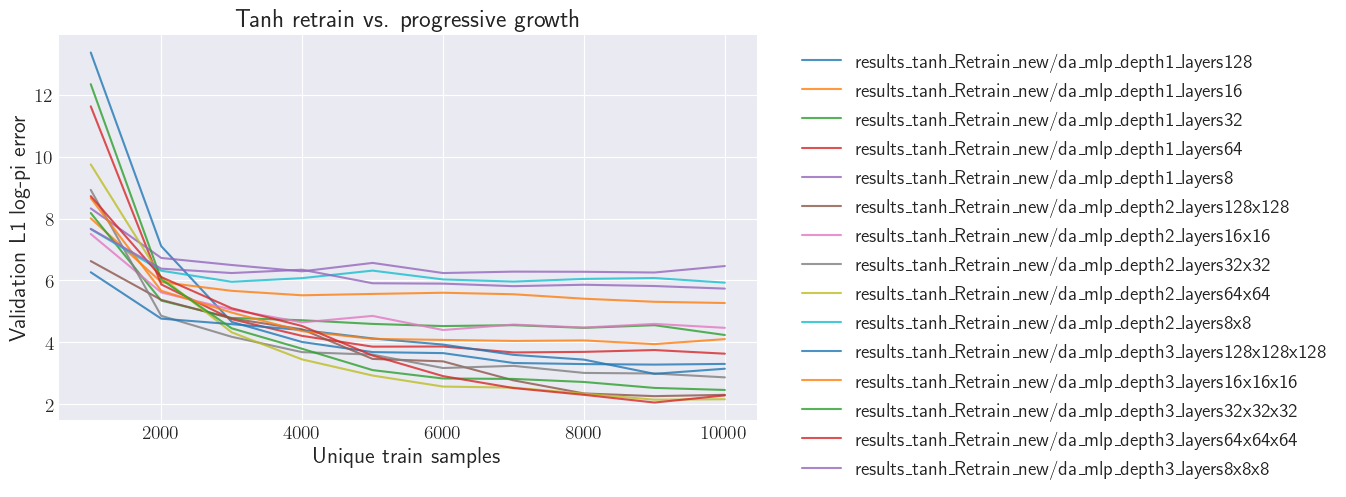

In [ ]:
tanh_vs_growth = plot_folder_metrics(
    folder="results_tanh_L1",
    x_col="unique_train_size",
    y_col="val_logpi_l1_error",
    xlabel="Unique train samples",
    ylabel="Validation L1 log-pi error",
    title="Tanh retrain vs. progressive growth",
    overlay_lines=[
        {
            "path": "mlp_growth_progress_new.csv",
            "label": "Growth progress (master_val_error)",
            "x_col": "train_limit",
            "y_col": "master_val_error",
            "linestyle": ":",
            "linewidth": 3.0,
            "color": "black",
            "x_transform": "half_plus_one",
        }
    ],
)
plt.show()


#### Filtering by depth / layer size

Use `make_depth_layer_matcher` to keep only the configurations you care about.
Below we look at the depth-2 tanh retrain runs whose layer sizes are `16x16` or
`32x32`. Adjust the lists to match your needs.


Dense MLP figure saved to dense_mlp.png


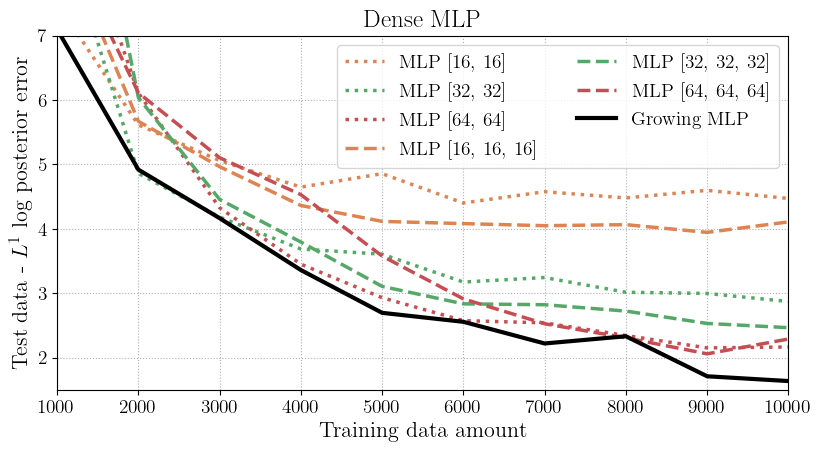

In [234]:
depth2_filter = make_depth_layer_matcher(
    depths=[2, 3],
    layer_sizes=[ "layers16", "layers32", "layers64"],
)

FIGSIZE_DENSE = (8.5, 4.8)
FONTSIZE_DENSE = 16
DENSE_FIGURE_PATH = Path("dense_mlp.png")

dense_series = load_series_from_folder(
    folder="results_tanh_Retrain_new",
    x_col="unique_train_size",
    y_col="val_logpi_l1_error",
    matcher=depth2_filter,
)

dense_overlay_spec = {
    "path": "mlp_grow_progress/mlp_growth_progress_new.csv",
    "label": "Growing MLP",
    "x_col": "train_limit",
    "y_col": "master_val_error",
    "x_transform": "half_plus_one",
}

dense_overlay = load_overlay_series(
    dense_overlay_spec,
    default_x_col="unique_train_size",
    default_y_col="val_logpi_l1_error",
)

fig, ax = init_publication_axes(figsize=FIGSIZE_DENSE, font_size=FONTSIZE_DENSE)

styled_entries = []
for entry in dense_series:
    meta = parse_architecture(entry["path"])
    if not meta["layers"]:
        continue
    styled_entries.append((entry, meta))

styled_entries.sort(key=lambda item: ((item[1]["depth"] or 0), tuple(item[1]["layers"])))

seen_labels = set()
for entry, meta in styled_entries:
    base_width = meta["layers"][0]
    color = LAYER_COLOR_MAP.get(base_width, "#7f7f7f")
    linestyle = DEPTH_LINESTYLE_MAP.get(meta["depth"], "-")
    label = f"MLP [{', '.join(str(v) for v in meta['layers'])}]"
    display_label = label if label not in seen_labels else "_nolegend_"
    seen_labels.add(label)
    ax.plot(
        entry["x"],
        entry["y"],
        color=color,
        linestyle=linestyle,
        linewidth=2.5,
        label=display_label,
    )

if dense_overlay:
    ax.plot(
        dense_overlay["x"],
        dense_overlay["y"],
        color="black",
        linestyle="-",
        linewidth=3.0,
        label=dense_overlay["label"],
    )

ax.set_title("Dense MLP")
ax.set_xlabel("Training data amount")
ax.set_ylabel(r"Test data - $L^1$ log posterior error")
ax.set_xlim(1_000, 10_000)
ax.set_ylim(1.5, 7)
ax.legend(loc="upper right", ncol=2, frameon=True)
fig.tight_layout()
fig.savefig(DENSE_FIGURE_PATH, bbox_inches="tight")
print(f"Dense MLP figure saved to {DENSE_FIGURE_PATH}")
plt.show()

### Fixed-rank low-rank sweep vs. warm-started layers=3, width=1024

Here the training size column is `unique_train_samples` and the master
objective is already exposed via `master_logpi_l1`. We add an overlay from the
corresponding sweep located at `sweep_outputs_10/rank_mlp_layers3_width1024.csv`.


Low rank MLP figure saved to low_rank_mlp.pdf


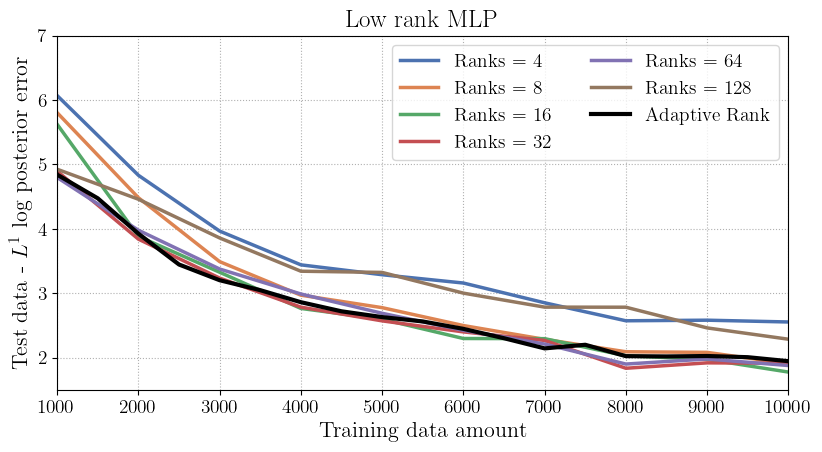

In [ ]:
FIGSIZE_LOW_RANK = (8.5, 4.8)
FONTSIZE_LOW_RANK = 16
LOW_RANK_FIGURE_PATH = Path("low_rank_mlp.pdf")

low_rank_series = load_series_from_folder(
    folder="results_fixed_rank_lowrank",
    x_col="unique_train_samples",
    y_col="master_logpi_l1",
)

filtered_low_rank = []
for entry in low_rank_series:
    rank = parse_rank(entry["path"])
    if rank is None or rank in {2, 256}:
        continue
    filtered_low_rank.append((entry, rank))

filtered_low_rank.sort(key=lambda item: item[1])

low_rank_overlay_spec = {
    "path": "adaptive_rank_1024/rank_mlp_layers3_width1024.csv",
    "label": "Adaptive Rank",
    "x_col": "unique_train_samples",
    "y_col": "master_logpi_l1",
}

low_rank_overlay = load_overlay_series(
    low_rank_overlay_spec,
    default_x_col="unique_train_samples",
    default_y_col="master_logpi_l1",
)

fig, ax = init_publication_axes(figsize=FIGSIZE_LOW_RANK, font_size=FONTSIZE_LOW_RANK)

seen_labels = set()
for entry, rank in filtered_low_rank:
    label = f"Ranks = {rank}"
    display_label = label if label not in seen_labels else "_nolegend_"
    seen_labels.add(label)
    ax.plot(
        entry["x"],
        entry["y"],
        color=LOW_RANK_COLOR_MAP.get(rank, "#7f7f7f"),
        linestyle="-",
        linewidth=2.5,
        label=display_label,
    )

if low_rank_overlay:
    ax.plot(
        low_rank_overlay["x"],
        low_rank_overlay["y"],
        color="black",
        linestyle="-",
        linewidth=3.0,
        label=low_rank_overlay["label"],
    )

ax.set_title("Low rank MLP")
ax.set_xlabel("Training data amount")
ax.set_ylabel(r"Test data - $L^1$ log posterior error")
ax.set_xlim(1_000, 10_000)
ax.set_ylim(1.5, 7)
ax.legend(loc="upper right", ncol=2, frameon=True)
fig.tight_layout()
fig.savefig(LOW_RANK_FIGURE_PATH, bbox_inches="tight")
print(f"Low rank MLP figure saved to {LOW_RANK_FIGURE_PATH}")
plt.show()
